# **CHECKPOINT 4**

# **Spark and GraphFrames Set Up**


In [1]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

# install the jar file for java
!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

# Get all the necessary queries 
!wget https://raw.githubusercontent.com/dmavrofridis/The-Exalted-Spartans/main/checkpoint-4/src/action_response_edges_query.sql
!wget https://raw.githubusercontent.com/dmavrofridis/The-Exalted-Spartans/main/checkpoint-4/src/action_response_vertices_query.sql
!wget https://raw.githubusercontent.com/dmavrofridis/The-Exalted-Spartans/main/checkpoint-4/src/force_edges_query.sql
!wget https://raw.githubusercontent.com/dmavrofridis/The-Exalted-Spartans/main/checkpoint-4/src/force_vertices_query.sql

# unzip the spark file to the current folder
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

# install pyspark
!pip3 install pyspark==3.2.0

# install graphframes
!pip3 install graphframes

--2021-12-01 05:04:01--  https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 52.85.79.76, 52.85.79.89, 52.85.79.83, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|52.85.79.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247880 (242K) [binary/octet-stream]
Saving to: ‘graphframes-0.8.2-spark3.2-s_2.12.jar’

graphframes-0.8.2-s 100%[===================>] 242.07K  --.-KB/s    in 0.03s   

2021-12-01 05:04:02 (8.02 MB/s) - ‘graphframes-0.8.2-spark3.2-s_2.12.jar’ saved [247880/247880]

--2021-12-01 05:04:02--  https://raw.githubusercontent.com/dmavrofridis/The-Exalted-Spartans/main/checkpoint-4/src/action_response_edges_query.sql
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.

Download the graphframes jar file from: [Graphframe jar file:](https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar)

Upload it in the Google Colab Files folder. Can be found in the left pane of this window.

In [2]:
!cp -v /content/graphframes-0.8.2-spark3.2-s_2.12.jar $SPARK_HOME/jars/

'/content/graphframes-0.8.2-spark3.2-s_2.12.jar' -> '/content/spark-3.2.0-bin-hadoop3.2/jars/graphframes-0.8.2-spark3.2-s_2.12.jar'


# **Imports**

In [3]:
#import the packages
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

findspark.init()

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
# access the postgresql server
conn = psycopg2.connect(
    host="codd04.research.northwestern.edu",
    port = "5433",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")

In [5]:
cursor = conn.cursor()

# **Query Functions**

In [6]:
def query_to_string(file_name):
    # Open and read the file as a single buffer
    fd = open(file_name, 'r')
    sqlFile = fd.read()
    fd.close()
    return sqlFile

In [7]:
cursor.execute("rollback")

# **Police Officers Partners**

In [8]:
cursor.execute(query_to_string("action_response_vertices_query.sql"), 
               {'action_response' : 5})
vertices = cursor.fetchall()


df_vertices_ar = pd.DataFrame(vertices)
colnames = [desc[0] for desc in cursor.description]
df_vertices_ar.columns = colnames

df_vertices_ar.drop_duplicates(['id'], keep='first', inplace=True)


In [9]:
cursor.execute(query_to_string("action_response_edges_query.sql"), {'action_response' : 5})
edges = cursor.fetchall()

df_edges_ar = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges_ar.columns = colnames

print(df_edges_ar.shape)


(29964, 3)


In [10]:
cursor.execute("SELECT officer_id_a as src, officer_id_b as dst FROM partners")
edges = cursor.fetchall()

df_edges_partners = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges_partners.columns = colnames


In [11]:
cursor.execute("SELECT id, first_name, last_name, race, gender, trr_percentile FROM data_officer")
vertices = cursor.fetchall()
df_vertices_partners = pd.DataFrame(vertices)
colnames = [desc[0] for desc in cursor.description]
df_vertices_partners.columns = colnames

# df_vertices_partners = df_vertices_partners.sample(1000)


In [12]:
df_vertices_partners.shape

(35545, 6)

In [13]:
spark_edges_p = spark.createDataFrame(df_edges_partners)
spark_vertices_p = spark.createDataFrame(df_vertices_partners)
# spark_vertices_p = spark_vertices_p.takeSample(False, 1000)
graph_partners = GraphFrame(spark_vertices_p, spark_edges_p)
graph_partners = graph_partners.dropIsolatedVertices()


In [14]:
spark_vertices_p.show()

+-----+----------+---------+-----+------+--------------------+
|   id|first_name|last_name| race|gender|      trr_percentile|
+-----+----------+---------+-----+------+--------------------+
|32312|   Randall|     Ryan|White|     M|63.00350000000000...|
|32358|     Kevin|    Stoll|White|     M|67.91100000000000...|
|32480|     David|    Lavin|White|     M|               0E-18|
|32491|     Kevin|     Rake|White|     M|               0E-18|
| 2680|   Richard|   Brandt|White|     M|                null|
|29553|      Hugh|Versteegh|White|     M|                null|
|19974|    Andrew|   Murcia|White|     M|                null|
| 8259|      Hugh|   Farmer|White|     M|                null|
|17716|   Anthony|  Matassa|White|     M|                null|
|19659|      John| Moriarty|White|     M|                null|
|32506|   Richard|  Francis|White|     M|               0E-18|
|29111|    Robert|    Tyson|Black|     M|                null|
| 1791|      Chas| Bennette|Black|     M|              

In [15]:
partner_pr = graph_partners.pageRank(tol=0.01)
partner_pr.vertices.sort(['pagerank'], ascending=False).show()

+-----+----------+----------+--------+------+--------------------+------------------+
|   id|first_name| last_name|    race|gender|      trr_percentile|          pagerank|
+-----+----------+----------+--------+------+--------------------+------------------+
|35493|    Andres|   Naranjo|Hispanic|     M|                null|6.3520486820168465|
|35488|  Angelina|     Cahue|Hispanic|     F|                null|6.3520486820168465|
|35474|    George|   Freeman|   Black|     M|                null|2.9286286668165373|
| 8516|      Gary|   Fillipo|   White|     M|               0E-18|2.7685288388728924|
|25864|   Matthew|     Scott|   White|     M|75.20710000000000...| 2.527241533998547|
|25521|     David|   Scafidi|   White|     M|78.27070000000000...|  2.50943978369884|
|15105|    Dennis|  Kounavis|   White|     M|49.10360000000000...| 2.495062723974873|
|28763|     Louis|    Torres|Hispanic|     M|93.47550000000000...|2.4587936178989325|
|31158|         J|   Wombles|   White|     M|38.902800

+----------+---------+--------+------+-----+--------------------+-----+
|first_name|last_name|    race|gender|   id|      trr_percentile|count|
+----------+---------+--------+------+-----+--------------------+-----+
|  Angelina|    Cahue|Hispanic|     F|35488|                null|   71|
|    Andres|  Naranjo|Hispanic|     M|35493|                null|   71|
|    George|  Freeman|   Black|     M|35474|                null|   49|
|   Pauline|    Heard|   Black|     F|11823|38.90280000000000...|   18|
|    Dennis| Kounavis|   White|     M|15105|49.10360000000000...|   18|
|         J|  Wombles|   White|     M|31158|38.90280000000000...|   18|
|    Pamela|    Smith|   Black|     F|26881|               0E-18|   16|
| Alexander|    Verta|   White|     M|35500|                null|   16|
|     Debra|   Howard|   Black|     F|12634|49.10360000000000...|   15|
|  Camillea|    Towns|   Black|     F|35545|                null|   15|
| Alexander| Strockis|   White|     M|35446|                null

(array([5.936e+03, 6.900e+01, 4.000e+01, 1.400e+01, 2.800e+01, 5.000e+00,
        1.000e+01, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 0.        ,  2.36666667,  4.73333333,  7.1       ,  9.46666667,
        11.83333333, 14.2       , 16.56666667, 18.93333333, 21.3       ,
        23.66666667, 26.03333333, 28.4       , 30.76666667, 33.13333333,
        35.5       , 37.86666667, 40.23333333, 42.6       , 44.96666667,
        47.33333333, 49.7       , 52.06666667, 54.43333333, 56.8       ,
        59.16666667, 61.53333333, 63.9       , 66.26666667, 68.63333333,
        71.        ]),
 <a list of 30 Patch objects>)

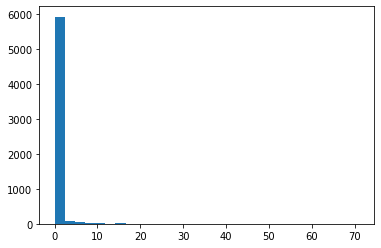

In [16]:
partner_tc = graph_partners.triangleCount()
partner_tc.sort(["count"], ascending=False).select("first_name", "last_name","race", "gender", "id", "trr_percentile", "count").show(30)
bins, counts = partner_tc.select('count').rdd.flatMap(lambda x: x).histogram(30)
plt.hist(bins[:-1], bins=bins, weights=counts)


###Action Response Graph Generation

In [17]:
spark_edges_ar = spark.createDataFrame(df_edges_ar)
spark_vertices_ar = spark.createDataFrame(df_vertices_ar)

In [18]:
graph_trr_ar = GraphFrame(spark_vertices_ar, spark_edges_ar)

In [19]:
trr_ar_pr = graph_trr_ar.pageRank(tol=0.01)
trr_ar_pr.vertices.sort(['pagerank'], ascending=False).show()

+----------+--------------+-----------+------+--------------------+---------+--------------------+-----+------------------+
|first_name|middle_initial|  last_name|gender|                race|trr_count|      trr_percentile|   id|          pagerank|
+----------+--------------+-----------+------+--------------------+---------+--------------------+-----+------------------+
|    Angelo|          null|    Mandile|     M|               White|       19|97.07820000000000...|17189| 7.089616680769733|
|     Chris|          null|Skarupinski|     M|               White|       26|98.97880000000000...|26540| 6.507207502428797|
|    George|             A|    Granias|     M|Native American/A...|       72|99.96030000000000...|10583| 5.977979208313248|
| Evangelos|          null|    Hitiris|     M|               White|       41|99.21710000000000...|12299| 5.415132634148123|
|   Gerardo|          null|       Vega|     M|            Hispanic|       27|98.59870000000000...|29454| 5.174587837329764|
|   Phil

In [20]:
highest_pr_trrs = trr_ar_pr.vertices.sort(['pagerank'], ascending=False).limit(1000)

In [21]:
highest_pr_trrs = highest_pr_trrs.toPandas()
highest_pr_trrs.columns = ["first_name", "mi", "last_name", "gender", "race", "trr_count", "trr_percentile","id", "page_rank"]

In [22]:
ids = highest_pr_trrs['id']
# print(ids)
associated_partner_page_rank = []
partner_pr_pd = partner_pr.vertices.toPandas()
# print(partner_pr_pd)
for id in ids:
  row = partner_pr_pd.loc[partner_pr_pd["id"] == id]
  if not row.empty:
    associated_partner_page_rank.append(row['pagerank'].tolist()[0])
    # print(row['pagerank'].tolist()[0])
  else:
    associated_partner_page_rank.append(None)

# print(associated_partner_page_rank)
highest_pr_trrs['partner_page_rank'] = associated_partner_page_rank
# print(highest_pr_trrs)

In [23]:
highest_pr_trrs.head(20)

,first_name,mi,last_name,gender,race,trr_count,trr_percentile,id,page_rank,partner_page_rank
0,Angelo,None,Mandile,M,White,19,97.078200000000000000,17189,7.089617,1.013898
1,Chris,None,Skarupinski,M,White,26,98.978800000000000000,26540,6.507208,NaN
2,George,A,Granias,M,Native American/Alaskan Native,72,99.960300000000000000,10583,5.977979,NaN
3,Evangelos,None,Hitiris,M,White,41,99.217100000000000000,12299,5.415133,NaN
4,Gerardo,None,Vega,M,Hispanic,27,98.598700000000000000,29454,5.174588,1.566724
5,Phillip,E,Orlando,M,Hispanic,41,99.217100000000000000,21371,4.832864,NaN
6,Nicholas,G,Harris,M,White,14,93.935100000000000000,11511,4.812834,NaN
7,Vincent,P,Baldassano,M,White,21,94.871200000000000000,31815,4.794225,NaN
8,Christoph,M,Saladino,M,Hispanic,26,96.845600000000000000,25155,4.665365,0.654806
9,Nellie,None,Harb,F,Hispanic,22,95.381800000000000000,11384,4.610932,NaN


+----------+----------+--------+------+-----+--------------------+-----+
|first_name| last_name|    race|gender|   id|      trr_percentile|count|
+----------+----------+--------+------+-----+--------------------+-----+
|   Phillip|   Orlando|Hispanic|     M|21371|99.21710000000000...|  157|
|     James|      Wynn|   White|     M|31337|93.66280000000000...|  130|
|      Ryan|     Harty|   White|     M|11615|95.38180000000000...|  113|
|     Steve|    Jarosz|   White|     M|13313|96.06260000000000...|  111|
|     Wayne|    Wiberg|   White|     M|30561|97.83840000000000...|  102|
|    Robert|  Mccallum|   White|     M|32175|96.84560000000000...|  102|
|      Mark|  O Connor|   White|     M|20860|72.10940000000000...|   97|
|   Jeffrey|    Felton|   White|     M| 8349|67.91100000000000...|   94|
|     Glenn|     Evans|   Black|     M| 8138|94.87120000000000...|   93|
|     Kevin|   Connors|   White|     M| 5204|72.10940000000000...|   93|
|   Richard|  Antonsen|   White|     M|  761|86.684

(array([3.565e+03, 6.560e+02, 1.690e+02, 1.170e+02, 6.400e+01, 4.500e+01,
        5.600e+01, 8.000e+00, 1.900e+01, 1.100e+01, 2.900e+01, 5.000e+00,
        1.000e+01, 8.000e+00, 1.000e+00, 5.000e+00, 0.000e+00, 1.000e+01,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.        ,   5.23333333,  10.46666667,  15.7       ,
         20.93333333,  26.16666667,  31.4       ,  36.63333333,
         41.86666667,  47.1       ,  52.33333333,  57.56666667,
         62.8       ,  68.03333333,  73.26666667,  78.5       ,
         83.73333333,  88.96666667,  94.2       ,  99.43333333,
        104.66666667, 109.9       , 115.13333333, 120.36666667,
        125.6       , 130.83333333, 136.06666667, 141.3       ,
        146.53333333, 151.76666667, 157.        ]),
 <a list of 30 Patch objects>)

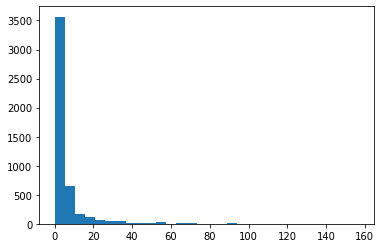

In [24]:
trr_ar_tc = graph_trr_ar.triangleCount()
trr_ar_tc.sort(["count"], ascending=False).select("first_name", "last_name","race", "gender", "id", "trr_percentile", "count").show(30)
bins, counts = trr_ar_tc.select('count').rdd.flatMap(lambda x: x).histogram(30)
plt.hist(bins[:-1], bins=bins, weights=counts)

# **Use of Force**


In [25]:
cursor.execute(query_to_string("force_edges_query.sql"))
edges = cursor.fetchall()

df_edges_f = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges_f.columns = colnames

In [26]:
cursor.execute(query_to_string("force_vertices_query.sql"))
vertices = cursor.fetchall()


df_vertices_f = pd.DataFrame(vertices)
colnames = [desc[0] for desc in cursor.description]
df_vertices_f.columns = colnames

df_vertices_f.drop_duplicates(['id'], keep='first', inplace=True)

In [27]:
spark_edges_f = spark.createDataFrame(df_edges_f)
spark_vertices_f = spark.createDataFrame(df_vertices_f)
graph_force = GraphFrame(spark_vertices_f, spark_edges_f)

In [28]:
f_pr = graph_force.pageRank(tol=0.01)
highest_f_pr = f_pr.vertices.sort(['pagerank'], ascending=False).limit(1000)
highest_f_pr = highest_f_pr.toPandas()

ids = highest_f_pr['id']
# print(ids)
associated_partner_page_rank = []
partner_pr_pd = partner_pr.vertices.toPandas()
# print(partner_pr_pd)
for id in ids:
  row = partner_pr_pd.loc[partner_pr_pd["id"] == id]
  if not row.empty:
    associated_partner_page_rank.append(row['pagerank'].tolist()[0])
    # print(row['pagerank'].tolist()[0])
  else:
    associated_partner_page_rank.append(None)

# print(associated_partner_page_rank)
highest_f_pr['partner_page_rank'] = associated_partner_page_rank

In [29]:
highest_f_pr.head(20)

,allegation_id,race,id,pagerank,partner_page_rank
0,1006219,Black,8138,9.340602,NaN
1,1024627,White,17816,7.564095,NaN
2,1013586,Hispanic,25306,7.011603,NaN
3,1005133,White,2375,6.942383,NaN
4,1042613,White,2356,6.330553,NaN
5,1011304,White,3277,6.053319,NaN
6,C217232,White,29033,5.728800,1.013898
7,C141303,White,27392,5.694141,NaN
8,C171608,White,8562,5.467520,NaN
9,C181200,Hispanic,4212,5.437083,NaN


+-----+-----+
|   id|count|
+-----+-----+
|30337| 1363|
|31536| 1340|
| 2375| 1229|
| 2356| 1217|
|21364| 1215|
|25230| 1197|
| 9648| 1189|
| 4226| 1182|
| 1832| 1147|
| 4565| 1146|
|20616| 1143|
|32072| 1141|
|32390| 1140|
| 6704| 1140|
|27668| 1136|
|12947| 1136|
|25983| 1135|
|28601| 1134|
| 1739| 1131|
|13093| 1131|
|29252| 1131|
| 4254| 1131|
|28384| 1131|
|28178| 1131|
|  560| 1130|
| 1517| 1130|
| 7032| 1129|
|24063| 1129|
|14710| 1129|
|19798| 1128|
+-----+-----+
only showing top 30 rows



(array([1.2362e+04, 6.3400e+02, 2.1200e+02, 6.8000e+01, 3.2000e+01,
        4.8000e+01, 3.0000e+00, 1.8000e+01, 1.4000e+01, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3000e+01,
        8.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([   0.        ,   45.43333333,   90.86666667,  136.3       ,
         181.73333333,  227.16666667,  272.6       ,  318.03333333,
         363.46666667,  408.9       ,  454.33333333,  499.76666667,
         545.2       ,  590.63333333,  636.06666667,  681.5       ,
         726.93333333,  772.36666667,  817.8       ,  863.23333333,
         908.66666667,  954.1       ,  999.53333333, 1044.96666667,
        1090.4       , 1135.83333333, 1181.26666667, 1226.7       ,
        1272.13333333, 1317.56666667, 1363.        ]),
 <a list of 30 Patch objects>)

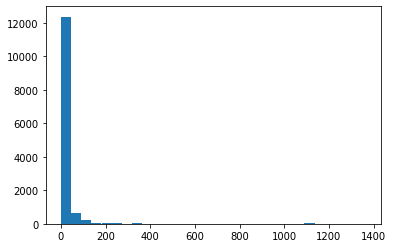

In [30]:
trr_f_tc = graph_force.triangleCount()
trr_f_tc.sort(["count"], ascending=False).select("id", "count").show(30)
bins, counts = trr_f_tc.select('count').rdd.flatMap(lambda x: x).histogram(30)
plt.hist(bins[:-1], bins=bins, weights=counts)

# **Graph Functions**

In [31]:


def plot_graph_no_color(gx, size_px, dpi, output_name):
    g = nx.DiGraph(directed = False)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])
    fig = plt.figure(1, figsize=(size_px, size_px), dpi=dpi)
    race_map = {'White' : 'blue',
                'Black' : 'orange',
                'Asian/Pacific' : 'green',
                'Native American/Alaskan Native' : 'black',
                'Hispanic' : 'yellow',
                'Other' : 'purple'}
    
    print(g.nodes())
    races = [race_map.get(gx.vertices.filter(gx.vertices['id'] == node).select('race').collect()[0][0]) for node in g.nodes()]
    nx.draw(g, with_labels=True, arrows = False, node_color=races, edge_color='black', font_color='purple')
    plt.savefig(output_name, dpi=dpi, bbox_inches='tight')

   

In [32]:
# NetworkX to visualize the graph
import networkx as nx

def plot_graph(gx, size_px, dpi, output_name):
    g = nx.DiGraph(directed = False)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])
    fig = plt.figure(1, figsize=(size_px, size_px), dpi=dpi)

    race_map = {'White' : 'blue',
                'Black' : 'orange',
                'Asian/Pacific' : 'green',
                'Native American/Alaskan Native' : 'black',
                'Hispanic' : 'yellow',
                'Other' : 'purple'}
    
    print(g.nodes())
    races = [race_map.get(gx.vertices.filter(gx.vertices['id'] == node).select('race').collect()[0][0]) for node in g.nodes()]
    nx.draw(g, with_labels=True, arrows = False, node_color=races, edge_color='black', font_color='purple')
    plt.savefig(output_name, dpi=dpi, bbox_inches='tight')

    print(races)
    

#Graph Visualization

[1, 27263, 17593, 2202, 12039, 16404, 27962, 23920, 15, 21371, 24710, 29992, 13773, 22256, 29517, 17259, 17634, 16615, 27084, 25789, 29768, 16, 32182, 13348, 21517, 25933, 32401, 25751, 18609, 19, 20544, 19984, 34, 23520, 42, 2110, 27673, 1989, 18656, 26516, 32181, 16124, 432, 44, 24844, 51, 5456, 16201, 15169, 28444, 52, 6564, 8726, 29491, 6087, 56, 28797, 24924, 60, 31294, 32246, 25442, 6560, 22195, 9473, 19633, 75, 11384, 115, 15906, 4263, 119, 29215, 22487, 2575, 135, 11831, 11808, 18529, 31843, 9627, 28287, 2241, 476, 781, 25032, 7998, 21283, 4698, 142, 22827, 29788, 143, 22809, 3647, 149, 3724, 18093, 28795, 32007, 13209, 31189, 15734, 152, 12379, 30505, 5554, 14619, 14603, 15855, 1009, 171, 25511, 7718, 22254, 178, 24079, 31422, 204, 26195, 208, 15228, 709, 4467, 23961, 209, 15753, 31922, 1695, 23425, 23829, 233, 18972, 32135, 241, 27479, 21654, 242, 24686, 29838, 13605, 8138, 12234, 244, 20661, 29592, 1056, 247, 18721, 11874, 256, 8894, 262, 10894, 9283, 29594, 11129, 10935, 20

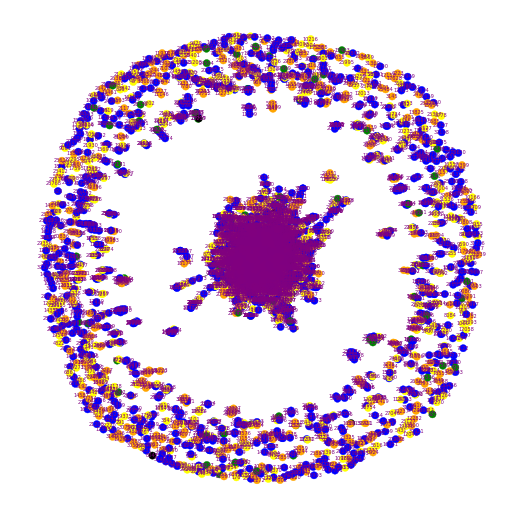

In [33]:
plot_graph(graph_trr_ar, 17, 30, 'action_response.png')

In [ ]:
#plot_graph(graph_force, 150, 40, 'use_of_force.png')

In [ ]:
#plot_graph(graph_partners, 15, 8, "partners.png")